In [1]:
import numpy as np
import matplotlib.pyplot as plt
import qnmfits
import CCE 
from likelihood_funcs import * 
from GP_funcs import *
import corner
import scipy
import pickle 

In [2]:
fig_width = 246.0 * (1.0 / 72.27)
fig_height = fig_width / 1.618 

In [3]:
id = "0001"
DT = 0.5

sim_main = CCE.SXS_CCE(id, lev="Lev5", radius="R2")
new_times = np.arange(sim_main.times[0], sim_main.times[-1], DT)
sim_main = sim_interpolator(sim_main, new_times)

In [4]:
n_max = 6

t0 = 5
T = 50

analysis_mask = (sim_main.times >= t0 - 1e-9) & (sim_main.times < t0+T - 1e-9)
analysis_times = sim_main.times[analysis_mask]

qnm_list = [(2,2,n,1) for n in np.arange(0, n_max+1)]
spherical_modes = [(2, 2)]

chif_mag_0 = sim_main.chif_mag
Mf_0 = sim_main.Mf

In [5]:
ls_fit = qnmfits.multimode_ringdown_fit(
    sim_main.times,
    sim_main.h,
    modes=qnm_list,
    Mf=Mf_0,
    chif=chif_mag_0,
    t0=t0,
    T=T,
    spherical_modes=spherical_modes,
)

C_0 = ls_fit["C"]

true_params = []
for re_c, im_c in zip(np.real(ls_fit["C"]), np.imag(ls_fit["C"])):
    true_params.append(re_c)
    true_params.append(im_c)

In [6]:
with open('param_dict_sim_lm_full.pkl', 'rb') as f:
    param_dict_sim_lm = pickle.load(f)

with open('f_dict_sim_lm_full.pkl', 'rb') as f:
    f_dict_sim_lm = pickle.load(f)

tuning_hyperparams_s = [0.4011230468749995] 
tuning_hyperparams = [1.321358102430008, -0.01345115218261082, 4.093379916592142, 0.5113668268176057] 
tuning_hyperparams_c = [1.316402500108596, 0.4326335562654318, -0.13408450413327633, 4.039978781750003, 0.1971672415404262, 4.933667981055878, 4.969654116813137, -0.35133507763297867] 

hyperparam_rule_dict_s = {
    "sigma_max": "multiply",
}

hyperparam_rule_dict = {
    "sigma_max": "multiply",
    "t_s": "sum",
    "length_scale": "multiply",
    "period": "multiply",
}

hyperparam_rule_dict_c = {
    "sigma_max": "multiply",
    "t_s": "sum",
    "sharpness": "sum",
    "length_scale": "multiply",
    "period": "multiply",
    "length_scale_2": "multiply",
    "period_2": "multiply",
    "a": "sum",
}

tuned_param_dict_s = {} 
tuned_param_dict = {} 
tuned_param_dict_c = {} 

for mode in param_dict_sim_lm[id].keys():
    tuned_param_dict_s[mode] = get_new_params(param_dict_sim_lm[id][mode], tuning_hyperparams_s, hyperparam_rule_dict_s)
    tuned_param_dict[mode] = get_new_params(param_dict_sim_lm[id][mode], tuning_hyperparams, hyperparam_rule_dict)
    tuned_param_dict_c[mode] = get_new_params(param_dict_sim_lm[id][mode], tuning_hyperparams_c, hyperparam_rule_dict_c)

In [22]:
n_times = len(analysis_times)

kernel_dict_s = {} 

for (ell, m) in spherical_modes:
    kernel_dict_s[(ell, m)] = kernel_s(np.asarray(analysis_times), **tuned_param_dict_s[ell,m]) + np.eye(len(analysis_times)) * 1e-13

kernel_dict = {}

for (ell, m) in spherical_modes:
    kernel_dict[(ell, m)] = kernel(np.asarray(analysis_times), **tuned_param_dict[ell,m]) + np.eye(len(analysis_times)) * 1e-13

kernel_dict_c = {}

for (ell, m) in spherical_modes:
    kernel_dict_c[(ell, m)] = kernel_c(np.asarray(analysis_times), **tuned_param_dict_c[ell,m]) + np.eye(len(analysis_times)) * 1e-13

In [23]:
kernel_dict_inv_s = {(ell,m): np.linalg.inv(kernel_dict_s[ell,m]) for ell,m in spherical_modes}
kernel_dict_inv = {(ell,m): np.linalg.inv(kernel_dict[ell,m]) for ell,m in spherical_modes}
kernel_dict_inv_c = {(ell,m): np.linalg.inv(kernel_dict_c[ell,m]) for ell,m in spherical_modes}

# Convert kernel_dict_inv to a matrix
kernel_matrix_inv_s = np.zeros((len(spherical_modes), n_times, n_times), dtype=np.complex128)
kernel_matrix_inv = np.zeros((len(spherical_modes), n_times, n_times), dtype=np.complex128)
kernel_matrix_inv_c = np.zeros((len(spherical_modes), n_times, n_times), dtype=np.complex128)

for idx, (ell, m) in enumerate(spherical_modes):
    kernel_matrix_inv_s[idx, :, :] = kernel_dict_inv_s[(ell, m)]

for idx, (ell, m) in enumerate(spherical_modes):
    kernel_matrix_inv[idx, :, :] = kernel_dict_inv[(ell, m)]

for idx, (ell, m) in enumerate(spherical_modes):
    kernel_matrix_inv_c[idx, :, :] = kernel_dict_inv_c[(ell, m)]

In [ ]:
fisher_matrix_s = get_fisher_matrix(qnm_list, spherical_modes, sim_main.times, Mf_0, chif_mag_0, kernel_matrix_inv_s, T=T)  
b_vec_s = get_b_vector(qnm_list, spherical_modes, t0, sim_main.times, sim_main.h, Mf_0, chif_mag_0, kernel_matrix_inv_s, T=T)

fisher_matrix = get_fisher_matrix(qnm_list, spherical_modes, sim_main.times, Mf_0, chif_mag_0, kernel_matrix_inv, T=T)
b_vec = get_b_vector(qnm_list, spherical_modes, t0, sim_main.times, sim_main.h, Mf_0, chif_mag_0, kernel_matrix_inv, T=T)

fisher_matrix_c = get_fisher_matrix(qnm_list, spherical_modes, sim_main.times, Mf_0, chif_mag_0, kernel_matrix_inv_c, T=T)
b_vec_c = get_b_vector(qnm_list, spherical_modes, t0, sim_main.times, sim_main.h, Mf_0, chif_mag_0, kernel_matrix_inv_c, T=T)

Precomputation time:  0.00046443939208984375
Fisher matrix computation time:  0.003389120101928711
Precomputation time:  0.00039458274841308594
Fisher matrix computation time:  0.0034477710723876953
Precomputation time:  0.00029850006103515625
Fisher matrix computation time:  0.0030236244201660156


In [32]:
mean_vector_s = np.linalg.solve(fisher_matrix_s, b_vec_s)
mean_vector = np.linalg.solve(fisher_matrix, b_vec)
mean_vector_c = np.linalg.solve(fisher_matrix_c, b_vec_c)

covariance_matrix_s = np.linalg.inv(fisher_matrix_s)
covariance_matrix = np.linalg.inv(fisher_matrix)
covariance_matrix_c = np.linalg.inv(fisher_matrix_c)

In [33]:
covariance_matrix_reg_s = covariance_matrix_s + np.eye(covariance_matrix_s.shape[0]) * 1e-12
covariance_matrix_reg = covariance_matrix + np.eye(covariance_matrix.shape[0]) * 1e-12
covariance_matrix_reg_c = covariance_matrix_c + np.eye(covariance_matrix_c.shape[0]) * 1e-12

TODO do this in amplitude / phase space 

/home/rvnd2/.local/lib/python3.11/site-packages/scipy/stats/_multivariate.py:757: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  out = random_state.multivariate_normal(mean, cov, size)


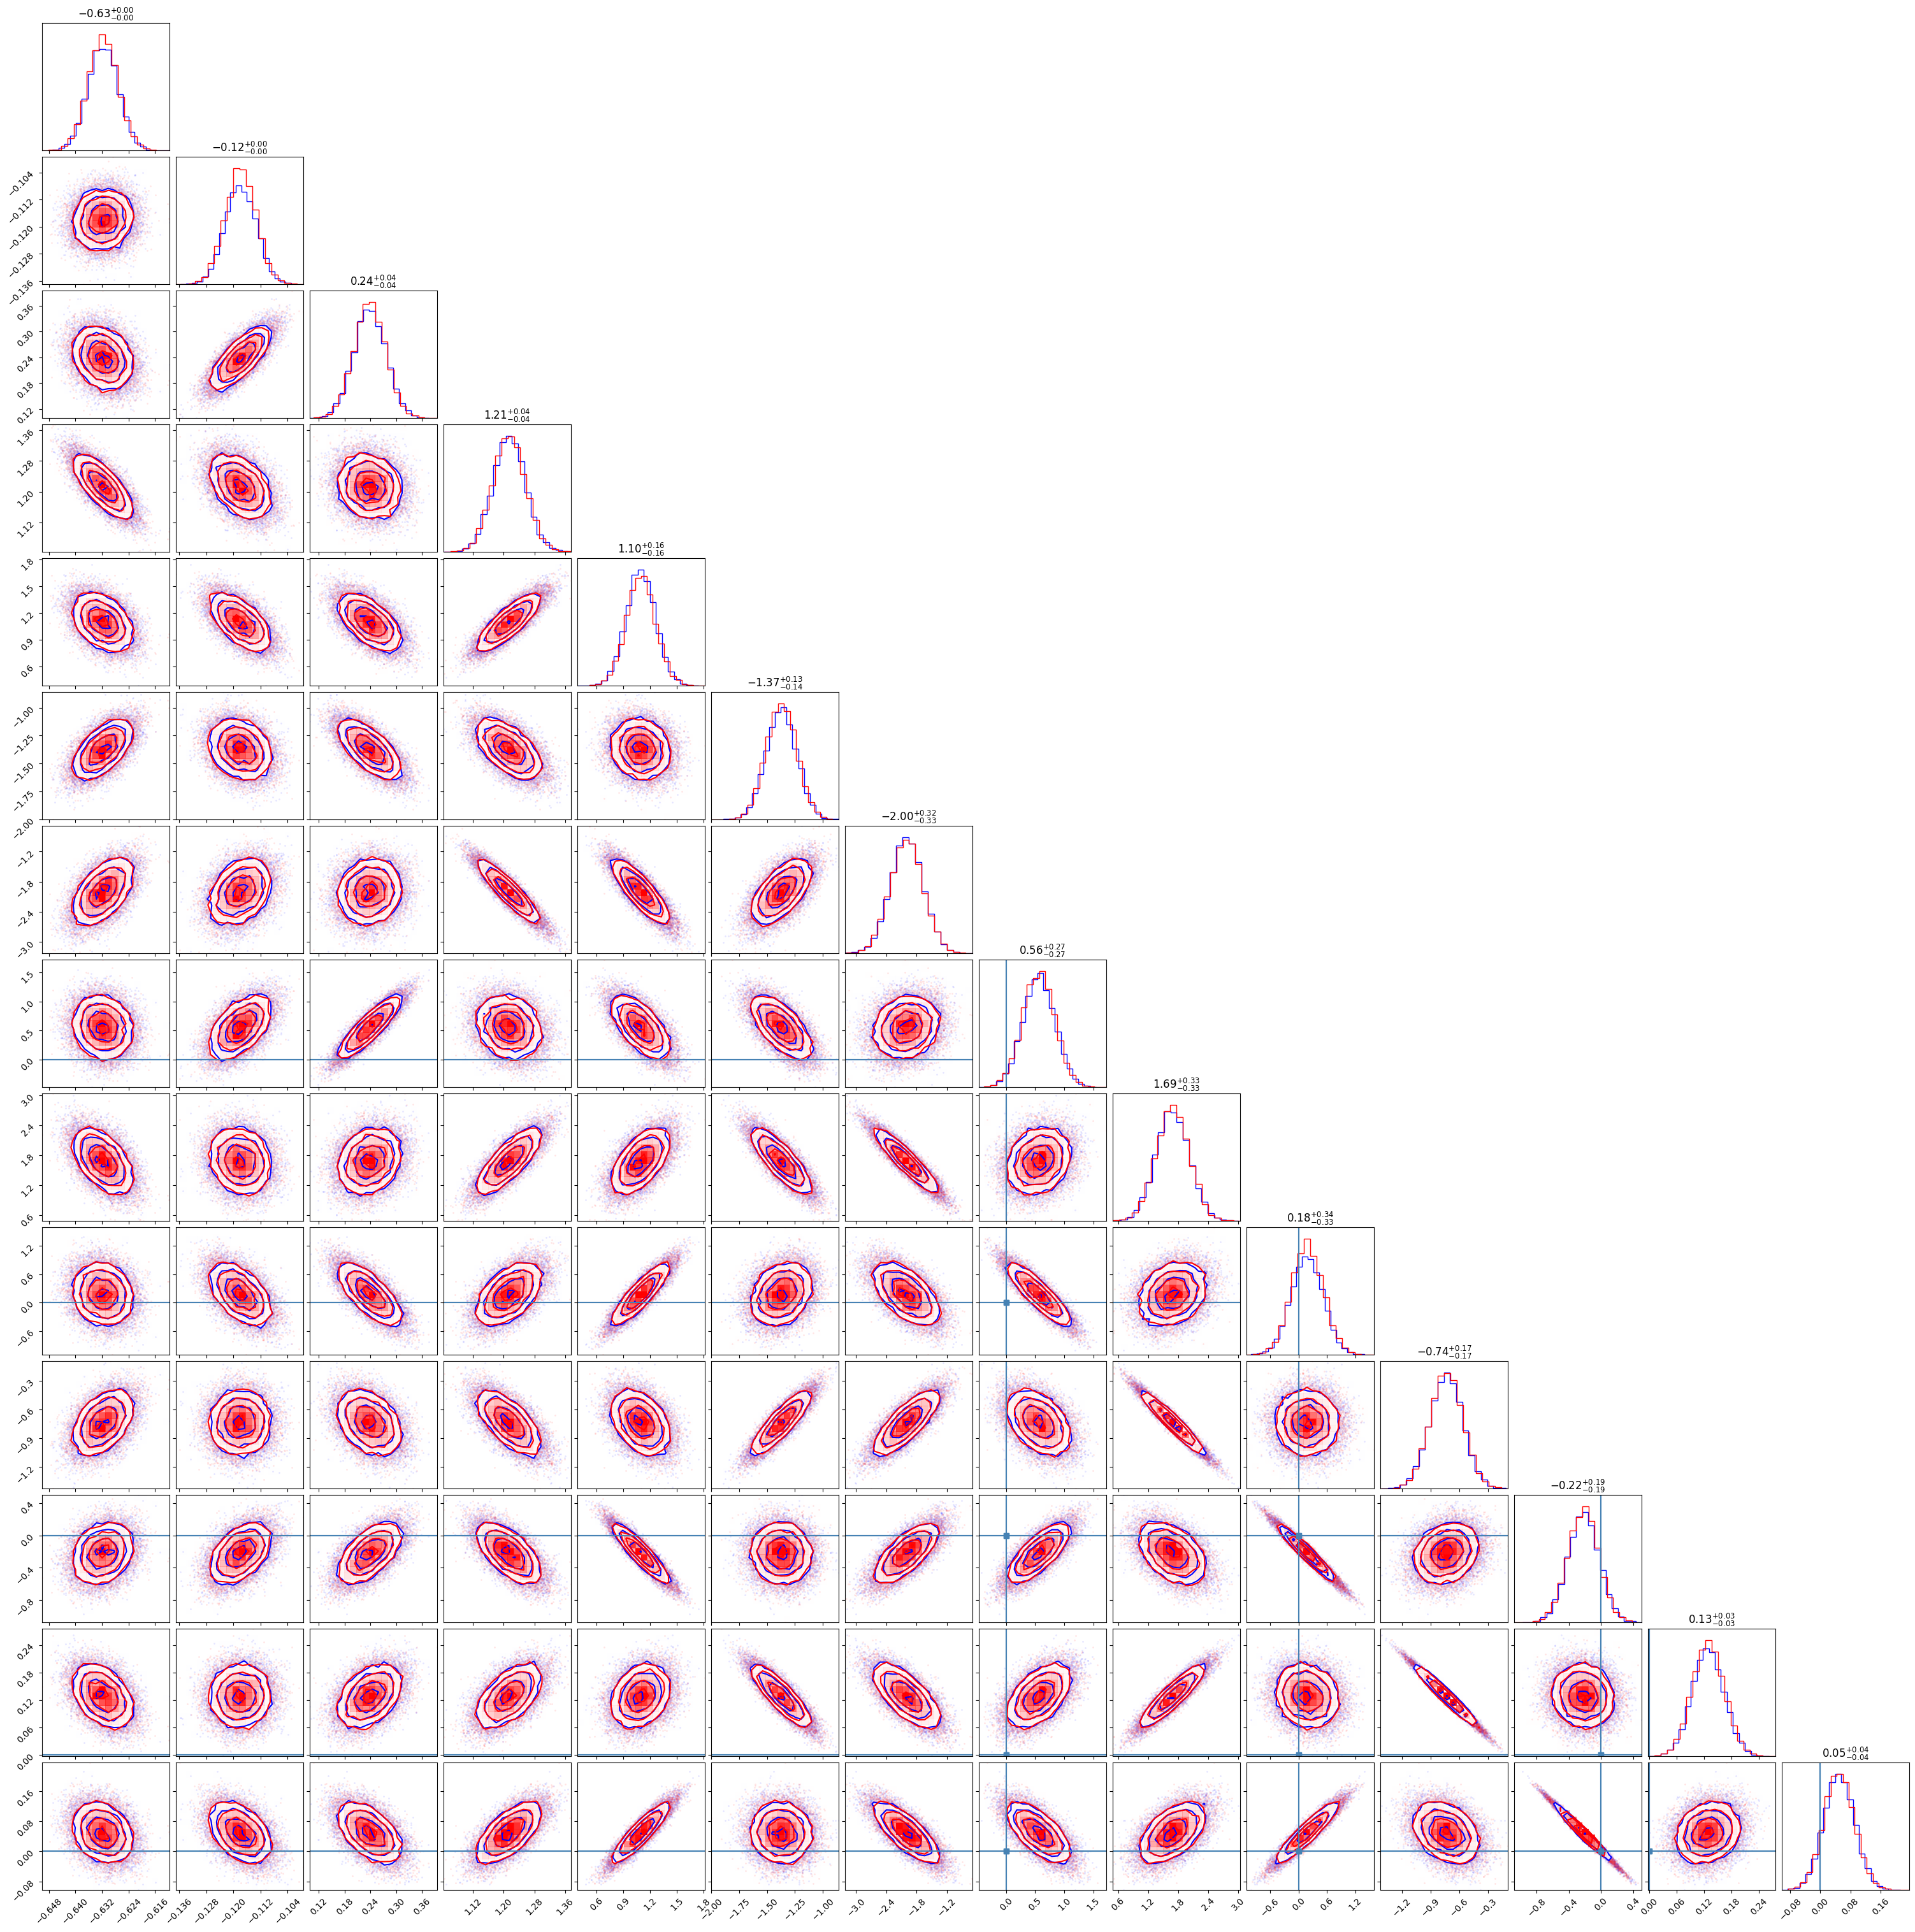

In [34]:
samples_s = scipy.stats.multivariate_normal(mean_vector_s, covariance_matrix_reg_s, allow_singular=True).rvs(
    size=10000
)

samples = scipy.stats.multivariate_normal(mean_vector, covariance_matrix_reg, allow_singular=True).rvs(
    size=10000
)

samples_c = scipy.stats.multivariate_normal(mean_vector_c, covariance_matrix_reg_c, allow_singular=True).rvs(
    size=10000
)
"""
.corner(
    samples_s,
    truths=np.array(true_params) * 0,
    color='red',
    fig=figure,
    label_kwargs={"fontsize": 12},
    show_titles=True,
    title_kwargs={"fontsize": 12}
)
"""

figure = corner.corner(
    samples,
    truths = np.array(true_params) * 0,
    color='blue',
    label_kwargs={"fontsize": 12},
    show_titles=True,
    title_kwargs={"fontsize": 12}
)

corner.corner(
    samples_c,
    truths=np.array(true_params) * 0,
    color='red',
    fig=figure,
    label_kwargs={"fontsize": 12},
    show_titles=True,
    title_kwargs={"fontsize": 12}
) 
plt.show()